# Pulse sequence generator and measuring script

Performing constant test...
Applying constant pulse sequence with 10 pulses
Inter-pulse delay: 1000000 ns
Pulse 1: V=1.000V, I=-5.865e-05A, R=-3.41e+03Ω
Pulse 2: V=1.000V, I=-5.875e-05A, R=-3.40e+03Ω
Pulse 3: V=1.000V, I=-5.985e-05A, R=-3.34e+03Ω
Pulse 4: V=1.000V, I=-5.841e-05A, R=-3.42e+03Ω
Pulse 5: V=1.000V, I=-5.929e-05A, R=-3.37e+03Ω
Pulse 6: V=1.000V, I=-5.936e-05A, R=-3.37e+03Ω
Pulse 7: V=1.000V, I=-5.848e-05A, R=-3.42e+03Ω
Pulse 8: V=1.000V, I=-5.829e-05A, R=-3.43e+03Ω
Pulse 9: V=1.000V, I=-5.909e-05A, R=-3.38e+03Ω
Pulse 10: V=1.000V, I=-5.883e-05A, R=-3.40e+03Ω


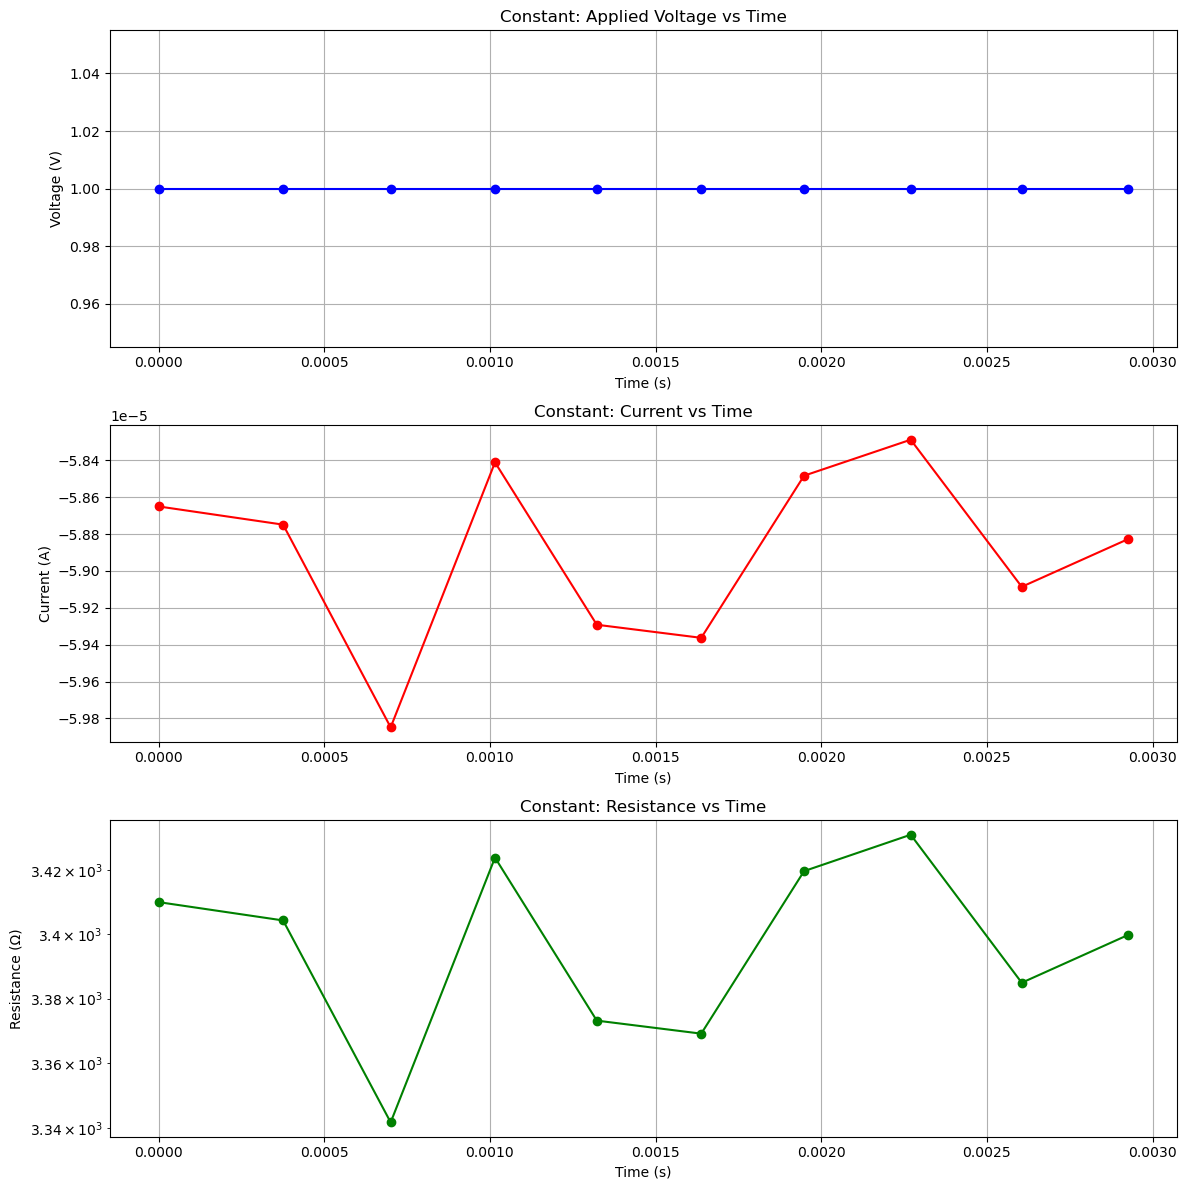

In [23]:
import pyarc2
from pyarc2 import Instrument,find_ids, ReadAt, ReadAfter, DataMode
import numpy as np
import matplotlib.pyplot as plt
import time

def create_pulse_sequence(sequence_type, **params):
    """
    Create different types of pulse sequences based on configuration.
    
    Parameters:
    -----------
    sequence_type : str
        Type of sequence ('constant', 'linear', 'set_reset', 'retention', etc.)
    params : dict
        Parameters specific to the sequence type
        
    Returns:
    --------
    list of tuples (voltage, duration_ns)
    """
    if sequence_type == 'constant':
        voltage = params.get('voltage', 1.0)
        count = params.get('count', 10)
        pulse_width = params.get('pulse_width', 100000)
        return [(voltage, pulse_width) for _ in range(count)]
    
    elif sequence_type == 'linear':
        start_v = params.get('start_v', 0.5)
        end_v = params.get('end_v', 2.0)
        count = params.get('count', 10)
        pulse_width = params.get('pulse_width', 100000)
        voltages = np.linspace(start_v, end_v, count)
        return [(v, pulse_width) for v in voltages]
    
    elif sequence_type == 'single_pulse':
        voltage = params.get('voltage', 1.0)
        pulse_width = params.get('pulse_width', 100000)
        count = params.get('count', 5)
        sequence = [(voltage, pulse_width)]
        sequence.extend([(0, pulse_width) for _ in range(count-1)])
        return sequence
    
    elif sequence_type == 'set_reset':
        set_v = params.get('set_v', 1.5)
        reset_v = params.get('reset_v', -1.5)
        pulse_width = params.get('pulse_width', 100000)
        cycles = params.get('cycles', 5)
        sequence = []
        for _ in range(cycles):
            sequence.append((set_v, pulse_width))
            sequence.append((reset_v, pulse_width))
        return sequence
    
    elif sequence_type == 'retention':
        init_v = params.get('init_v', 1.5)  
        read_count = params.get('read_count', 20)
        pulse_width = params.get('pulse_width', 100000)
        sequence = [(init_v, pulse_width)]
        sequence.extend([(0, pulse_width) for _ in range(read_count)])
        return sequence
    
    elif sequence_type == 'endurance':
        set_v = params.get('set_v', 1.5)
        reset_v = params.get('reset_v', -1.5)
        pulse_width = params.get('pulse_width', 100000)
        cycle_count = params.get('cycle_count', 100)
        sequence = []
        for _ in range(cycle_count):
            sequence.append((set_v, pulse_width))
            sequence.append((reset_v, pulse_width))
        return sequence
    
    elif sequence_type == 'custom':
        return params.get('sequence', [(1.0, 100000)])
    
    else:
        raise ValueError(f"Unknown sequence type: {sequence_type}")

def generate_pulse_sequence_with_readings_v2(
    instrument, 
    low, 
    high, 
    sequence_config=None,  # Configuration dictionary
    read_voltage=0.2,
    compliance_current=1e-3,  # 1mA compliance
    debug=False
):
    """
    Apply a sequence of pulses with readings after each pulse using sequence configuration.
    
    Parameters:
    -----------
    instrument : Instrument
        PyArC2 instrument instance
    low : int
        Low channel number
    high : int
        High channel number
    sequence_config : dict
        Dictionary containing:
            - 'type': str - Type of sequence ('constant', 'linear', 'set_reset', 'retention', etc.)
            - 'params': dict - Parameters specific to the sequence type
            - 'inter_pulse_delay': int - Delay between pulses in ns (default: 1000000)
    read_voltage : float
        Voltage used for reading resistance
    compliance_current : float
        Maximum current allowed during operation
    debug : bool
        Print debug information if True
        
    Returns:
    --------
    dict
        Dictionary containing measurement results
    """
    # Default configuration if none provided
    if sequence_config is None:
        sequence_config = {
            'type': 'constant',
            'params': {
                'voltage': 0.2,
                'count': 1,
                'pulse_width': 1_000_000
            },
            'inter_pulse_delay': 1_000_000
        }
    
    # Extract parameters
    sequence_type = sequence_config.get('type', 'constant')
    params = sequence_config.get('params', {})
    inter_pulse_delay = sequence_config.get('inter_pulse_delay', 1000000)
    
    # Generate pulse sequence based on configuration type
    pulse_sequence = create_pulse_sequence(sequence_type, **params)
    
    if debug:
        print(f"Applying {sequence_type} pulse sequence with {len(pulse_sequence)} pulses")
        print(f"Inter-pulse delay: {inter_pulse_delay} ns")
    
    # First, apply all pulses with the instrument's memory buffering
    for voltage, duration in pulse_sequence:
        # Apply pulse
        instrument.pulse_one(low, high, voltage, duration)
        
        instrument.generate_read_train(
            lows=[low],
            highs=[high],
            vread=read_voltage,
            nreads=1,
            inter_nanos=0,
            ground=True
        )
        
        if inter_pulse_delay > 0:
            instrument.delay(inter_pulse_delay)
    
    instrument.execute()
    instrument. wait()
    
    # Collect and process results
    voltages = []
    currents = []
    resistances = []
    timestamps = []
    
    for idx, current_data in enumerate(instrument.get_iter(DataMode.All)):
        # Record timestamp
        curr_timestamp = time.time()
        timestamps.append(curr_timestamp)
        
        # Get the corresponding pulse voltage
        if idx < len(pulse_sequence):
            voltage, duration = pulse_sequence[idx]
            voltages.append(voltage)
         
            # Extract current value for the high channel
            current = current_data[0][high]
            currents.append(current)
            
            # Calculate resistance
            if abs(current) > 1e-12:
                resistance = read_voltage / current 
            else:
                resistance = float('inf')
            resistances.append(resistance)
            
            if debug:
                print(f"Pulse {idx+1}: V={voltage:.3f}V, I={current:.3e}A, R={resistance:.2e}Ω")
            
            # Check for compliance
            if abs(current) > compliance_current:
                print(f"Compliance current exceeded ({abs(current):.3e} A > {compliance_current:.3e} A). Stopping sequence.")
                break  # Stop if compliance is exceeded
    
    return {
        'voltages': voltages,
        'currents': currents,
        'resistances': resistances,
        'timestamps': timestamps,
        'pulse_sequence': pulse_sequence,
        'sequence_config': sequence_config
    }

# Example usage of the new function
if __name__ == "__main__":
    # Initialize the instrument if not already done
    if 'arc' not in locals():
        ids = find_ids()
        if len(ids) == 0:
            print('no arc2')
        else:
            arc = Instrument(ids[0], '/home/abaigol/.local/share/arc2control/firmware/efm03_20240918.bin')
    
    # Example: Using a single-pulse test configuration
    single_pulse_config = {
        'type': 'single_pulse',
        'params': {
            'voltage': 1.0,
            'pulse_width': 100000,
            'count': 10
        },
        'inter_pulse_delay': 1000000  # 1 ms between operations
    }
    
    # Example: Using a SET/RESET test configuration
    set_reset_config = {
        'type': 'set_reset',
        'params': {
            'set_v': 1.0,
            'reset_v': -1.0,
            'pulse_width': 100000,
            'cycles': 3
        },
        'inter_pulse_delay': 1000000
    }

    endurance_config = {
        'type': 'endurance',
        'params': {
            'set_v': 1.0,
            'reset_v': -1.0,
            'pulse_width': 100000,
            'cycle_count': 100
        },
        'inter_pulse_delay': 1000000
    }

    retention_config = {
        'type': 'retention',
        'params': {
            'init_v': 1.0,
            'read_count': 10,
            'pulse_width': 100000
        },
        'inter_pulse_delay': 1000000
    }

    constant_config = {
        'type': 'constant',
        'params': {
            'voltage': 1.0,
            'count': 10,
            'pulse_width': 100000
        },
        'inter_pulse_delay': 1000000
    }
    
    # Choose which configuration to use
    active_config = constant_config
    
    print(f"Performing {active_config['type']} test...")
    results = generate_pulse_sequence_with_readings_v2(
        arc, 
        low=18, 
        high=13, 
        sequence_config=active_config,
        read_voltage=0.2,
        debug=True
    )
    
# Updated plotting code for generate_pulse_sequence_with_readings_v2

# Extract data from results
timestamps_array = np.array(results['timestamps'])
rel_times = timestamps_array - timestamps_array[0]  # Time relative to start

# Create figure with multiple subplots
plt.figure(figsize=(12, 12))

# Plot 1: Applied Voltage vs Time
plt.subplot(3, 1, 1)
plt.plot(rel_times, results['voltages'], 'o-', color='blue')
plt.title(f"{active_config['type'].replace('_', ' ').title()}: Applied Voltage vs Time")
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)

# Plot 2: Current vs Time
plt.subplot(3, 1, 2)
plt.plot(rel_times, results['currents'], 'o-', color='red')
plt.title(f"{active_config['type'].replace('_', ' ').title()}: Current vs Time")
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid(True)

# Plot 3: Resistance vs Time
plt.subplot(3, 1, 3)
plt.plot(rel_times, np.abs(results['resistances']), 'o-', color='green')
plt.title(f"{active_config['type'].replace('_', ' ').title()}: Resistance vs Time")
plt.xlabel('Time (s)')
plt.ylabel('Resistance (Ω)')
plt.yscale('log')  # Log scale often better for resistance
plt.grid(True)

plt.tight_layout()
plt.show()

# For SET/RESET tests, add a second figure showing pulse number
if active_config['type'] in ['set_reset', 'endurance']:
    plt.figure(figsize=(12, 6))
    
    # Create pulse numbers (1, 2, 3, etc.)
    pulse_numbers = np.arange(1, len(results['resistances']) + 1)
    
    # Plot resistance vs pulse number
    plt.plot(pulse_numbers, results['resistances'], 'o-', color='purple')
    plt.title(f"{active_config['type'].replace('_', ' ').title()}: Resistance vs Pulse Number")
    plt.xlabel('Pulse Number')
    plt.ylabel('Resistance (Ω)')
    plt.grid(True)
    
    # Mark SET and RESET pulses
    if len(pulse_numbers) > 1:
        plt.axvspan(0.5, 1.5, alpha=0.2, color='red', label='SET')
        for i in range(2, len(pulse_numbers) + 1, 2):
            plt.axvspan(i-0.5, i+0.5, alpha=0.2, color='red')
        
        for i in range(1, len(pulse_numbers) + 1, 2):
            if i > 1:  # Skip the first SET pulse
                plt.axvspan(i-0.5, i+0.5, alpha=0.2, color='blue', label='RESET' if i == 3 else "")
    
    plt.legend()
    plt.tight_layout()
    plt.show()